In [76]:
data_path = "leading_reviewer_data/"

In [77]:
from glob import glob
reviewer_path_list = glob(data_path+"*/")

In [214]:
import re
import os
import numpy as np
import nltk

In [215]:
SYSTEM_IS_WINDOW = False

In [224]:
# only use 10 reviews for each reviewer (pick out the 10 largest size of reviews)
reviewers = []
reviewers_review = []
reviewers_literature = []
reviewers_literature_single_multiple_author_word_count = np.zeros((len(reviewer_path_list),2)) # single first, multiple second
reviewer_index = 0
for reviewer_path in reviewer_path_list:
    if SYSTEM_IS_WINDOW:
        reviewers.append(re.search(r'leading_reviewer_data\\([a-zA-Z_-]*)\\',reviewer_path).group(1))
    else:
        reviewers.append(re.search(r'leading_reviewer_data/([a-zA-Z_-]*)/',reviewer_path).group(1))
    current_reviewer_review = [f for f in os.listdir(reviewer_path) if '.txt' in f]
    # select the 10 largest size of reviews
    current_selected_review_index = np.argsort([os.stat(reviewer_path+f).st_size for f in os.listdir(reviewer_path) if '.txt' in f])[::-1][:10]
    current_reviewer_review_selected = list(np.take(np.array(current_reviewer_review),current_selected_review_index))
    # get the review texts
    review_texts = []
    for nm in current_reviewer_review_selected:
        with open(reviewer_path+nm, encoding="utf8") as f:
            text_to_append = f.read().replace('\n',' ')
            review_texts.append(text_to_append)
    reviewers_review.append(review_texts)
    
    if SYSTEM_IS_WINDOW:
        current_reviewer_literature = [f for f in os.listdir(reviewer_path+"training_data\\") if '.txt' in f]
    else:
        current_reviewer_literature = [f for f in os.listdir(reviewer_path+"training_data/") if '.txt' in f]
    # get the literature texts
    literature_texts = []
    for nm in current_reviewer_literature:
        if SYSTEM_IS_WINDOW:
            text_nm = reviewer_path+"training_data\\"+nm
        else:
            text_nm = reviewer_path+"training_data/"+nm
        with open(text_nm, encoding="utf8") as f:
            text_to_append = f.read().replace('\n',' ')
            literature_texts.append(text_to_append)
        # count the words for single and multiple author literatures
        if re.search(r'-M.txt',nm) == None:
            # single author literature
            wordcount = len(nltk.word_tokenize(text_to_append))
            reviewers_literature_single_multiple_author_word_count[reviewer_index][0] += wordcount
        else:
            # multiple author literature
            wordcount = len(nltk.word_tokenize(text_to_append))
            reviewers_literature_single_multiple_author_word_count[reviewer_index][1] += wordcount
    reviewers_literature.append(literature_texts)
    
    reviewer_index += 1

# Build training set, development set and test set
## Randomly picking the test data from the whole dataset
total: 25 reviewers

each reviewer has 10 reviews and 10 literatures.

Test set: half of the reviews (each reviewer has 5 reviews)

Development set: the other half of the reviews

Training set: all the literatures

In [81]:
np.random.seed(100)
dev_set = []
test_set = []
for reviewer in reviewers_review:
    # copy() is important here, or the reviewers_review will be shuffled
    reviewer_cp = reviewer.copy()
    np.random.shuffle(reviewer_cp)
    dev_set.append(reviewer_cp[:5])
    test_set.append(reviewer_cp[5:])

# Features

In [82]:
from scipy.cluster.vq import whiten
from sklearn.feature_extraction.text import CountVectorizer
sentence_tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

## Bag of words feature

bag of words feature needs to build the corpus from review data

In [83]:
all_review_texts = [' '.join(sublib) for sublib in reviewers_review]
all_review_texts = ' '.join(all_review_texts)
all_tokens = nltk.word_tokenize(all_review_texts)

# word_to_ix maps each word in the vocab to a unique integer, which will be its index into the Bag of words vector
word_to_ix = {}
for word in all_tokens:
    if word not in word_to_ix:
        word_to_ix[word] = len(word_to_ix)
        
VOCAB_SIZE = len(word_to_ix)

NUM_TOP_WORDS = 500
# get most common words in the whole review set
fdist = nltk.FreqDist(all_tokens)
vocab_top = fdist.most_common(NUM_TOP_WORDS)
vocab_selected = [word_to_ix[voc[0]] for voc in vocab_top]

In [84]:
# the input_text can only be one literature
def BagOfWords(input_text, word_to_ix, vocab_selected):
    """
    Compute the bag of words feature vectors, based on the most common words
     in reviews
    """
    vec = torch.zeros(len(word_to_ix))
    tokens = nltk.word_tokenize(input_text)
    for word in tokens:
        if word in word_to_ix:
            vec[word_to_ix[word]] += 1
    # the bag of word vector
    vec = vec.view(1, -1)
    # the bow vector for the selected top words
    fvs_bow = torch.index_select(vec,1,torch.tensor(vocab_selected))
    fvs_bow /= torch.sum(vec)
    return fvs_bow

## Bag of characters features (n-gram)

In [85]:
GRAM_N = 3

import nltk
from nltk.util import ngrams
tokenizer_with_tail_pukt = nltk.tokenize.RegexpTokenizer(r'[a-zA-Z0-9-.()\[\]{}]+[,.:?!\"\']?')

def NGramCharacter(input_text,GRAM_N):
    all_tokens = tokenizer_with_tail_pukt.tokenize(input_text)
    N_gram = []
    for token in all_tokens:
        grams = list(ngrams(token,GRAM_N))
        for gm in grams:
            N_gram.append(''.join(gm))
    return N_gram

Build N-gram character vocabulary from reivews

In [86]:
all_review_texts = [' '.join(sublib) for sublib in reviewers_review]
all_review_texts = ' '.join(all_review_texts)
N_gram_char = NGramCharacter(all_review_texts,GRAM_N)

In [87]:
# ngram_to_ix maps each ngram in the vocab to a unique integer, which will be its index into the Bag of characters vector
ngram_to_ix = {}
for ngram in N_gram_char:
    if ngram not in ngram_to_ix:
        ngram_to_ix[ngram] = len(ngram_to_ix)
        
VOCAB_CHAR_SIZE = len(ngram_to_ix)

NUM_TOP_NGRAMS = 1000
# get most common ngrams in the whole review set
fdist = nltk.FreqDist(N_gram_char)
vocab_char_top = fdist.most_common(NUM_TOP_NGRAMS)
vocab_char_selected = [ngram_to_ix[voc[0]] for voc in vocab_char_top]


In [88]:
# the input_text can only be one literature
def BagOfCharacters(input_text, ngram_to_ix, vocab_char_selected):
    """
    Compute the bag of character feature vectors, based on the most common ngrams
     in reviews
    """
    GRAM_N = len(list(ngram_to_ix.keys())[0])
    
    vec = torch.zeros(len(ngram_to_ix))
    N_gram_char = NGramCharacter(input_text,GRAM_N)
    
    for ngram in N_gram_char:
        if ngram in ngram_to_ix:
            vec[ngram_to_ix[ngram]] += 1
    # the bag of chars vector
    vec = vec.view(1, -1)
    # the boc vector for the selected top chars
    fvs_boc = torch.index_select(vec,1,torch.tensor(vocab_char_selected))
    fvs_boc /= torch.sum(vec)
    return fvs_boc

## Syntactic features

In [89]:
tagdict = nltk.data.load('help/tagsets/upenn_tagset.pickle')
pos_list = list(tagdict.keys())

In [90]:
def SyntacticFeatures(reviews_texts, pos_list):
    """
    Extract feature vector for part of speech frequencies
    """
    # get part of speech for each token in each review
    def token_to_pos(ch):
        tokens = nltk.word_tokenize(ch)
        return [p[1] for p in nltk.pos_tag(tokens)]
    review_pos = [token_to_pos(ch) for ch in reviews_texts]
 
    # count frequencies for all POS types
    fvs_syntax = np.array([[ch.count(pos) for pos in pos_list] for ch in review_pos]).astype(np.float64)
 
    # normalise by dividing each row by number of tokens in the review
    fvs_syntax /= np.c_[np.array([len(ch) for ch in review_pos])]
    
    return fvs_syntax

# Classifier

## logistic regression (SGD and AdamGrad)

In [91]:
import sklearn

In [92]:
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable

torch.manual_seed(100)

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

### training data

In [93]:
fvs_boc_train = np.array([], dtype=np.int64).reshape(0,NUM_TOP_NGRAMS)
fvs_bow_train = np.array([], dtype=np.int64).reshape(0,NUM_TOP_WORDS)
fvs_syntax_train = np.array([], dtype=np.int64).reshape(0,len(pos_list))
true_label_train = np.array([], dtype=np.int64).reshape(0,1)
for lit in np.arange(len(reviewers_literature)):
    # bag of words
    for per_lit in reviewers_literature[lit]:
        fvs_bow_train_cur = BagOfWords(per_lit, word_to_ix, vocab_selected)
        fvs_bow_train = np.concatenate((fvs_bow_train,fvs_bow_train_cur))
    # bag of chars (n-grams)
    for per_lit in reviewers_literature[lit]:
        fvs_boc_train_cur = BagOfCharacters(per_lit, ngram_to_ix, vocab_char_selected)
        fvs_boc_train = np.concatenate((fvs_boc_train,fvs_boc_train_cur))
    # syntax
    fvs_syntax_train_cur = SyntacticFeatures(reviewers_literature[lit], pos_list)
    fvs_syntax_train = np.concatenate((fvs_syntax_train,fvs_syntax_train_cur))
    # label
    true_label_train = np.concatenate((true_label_train, lit*np.ones(( len(reviewers_literature[lit]) ,1))))

In [94]:
fvs_boc_train = sklearn.preprocessing.scale(fvs_boc_train)
fvs_bow_train = sklearn.preprocessing.scale(fvs_bow_train)
fvs_syntax_train = sklearn.preprocessing.scale(fvs_syntax_train)

In [95]:
fvs_train = np.concatenate((fvs_bow_train,fvs_syntax_train,fvs_boc_train),axis=1)

## Logistic Regression classifier

In [96]:
class LRClassifier(nn.Module):  # inheriting from nn.Module!

    def __init__(self, input_size, num_labels):
        # calls the init function of nn.Module.  Dont get confused by syntax,
        # just always do it in an nn.Module
        super(LRClassifier, self).__init__()

        # Define the parameters that you will need.  In this case, we need A and b,
        # the parameters of the affine mapping.
        # Torch defines nn.Linear(), which provides the affine map.
        # Make sure you understand why the input dimension is fvs_dim
        # and the output is num_labels!
        self.linear = nn.Linear(input_size, num_labels)

        # NOTE! The non-linearity log softmax does not have parameters! So we don't need
        # to worry about that here

    def forward(self, x):
        # Pass the input through the linear layer,
        # then pass that through log_softmax.
        # Many non-linearities and other functions are in torch.nn.functional
        out = self.linear(x)
        return out

In [165]:
NUM_LABELS = len(reviewers_literature)
INPUT_SIZE = fvs_train.shape[1]
input_vector = torch.from_numpy(fvs_train)
input_vector = input_vector.float()
input_vector = input_vector.to(device)
labels = torch.from_numpy(true_label_train)
labels = labels.view(-1)
labels = labels.long()
labels = labels.to(device)
model = LRClassifier(INPUT_SIZE, NUM_LABELS)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

num_epochs = 5000

# Training the Model
for epoch in range(num_epochs):    
    # Forward + Backward + Optimize
    optimizer.zero_grad()
    outputs = model(input_vector)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
        
    if epoch % 100 == 0:
        print ('Epoch: [%d/%d], Loss: %.4f' %(epoch+1, num_epochs, loss.data))

Epoch: [1/5000], Loss: 3.2992
Epoch: [101/5000], Loss: 0.2006
Epoch: [201/5000], Loss: 0.0808
Epoch: [301/5000], Loss: 0.0493
Epoch: [401/5000], Loss: 0.0353
Epoch: [501/5000], Loss: 0.0274
Epoch: [601/5000], Loss: 0.0224
Epoch: [701/5000], Loss: 0.0190
Epoch: [801/5000], Loss: 0.0164
Epoch: [901/5000], Loss: 0.0145
Epoch: [1001/5000], Loss: 0.0130
Epoch: [1101/5000], Loss: 0.0117
Epoch: [1201/5000], Loss: 0.0107
Epoch: [1301/5000], Loss: 0.0099
Epoch: [1401/5000], Loss: 0.0091
Epoch: [1501/5000], Loss: 0.0085
Epoch: [1601/5000], Loss: 0.0079
Epoch: [1701/5000], Loss: 0.0075
Epoch: [1801/5000], Loss: 0.0070
Epoch: [1901/5000], Loss: 0.0067
Epoch: [2001/5000], Loss: 0.0063
Epoch: [2101/5000], Loss: 0.0060
Epoch: [2201/5000], Loss: 0.0057
Epoch: [2301/5000], Loss: 0.0055
Epoch: [2401/5000], Loss: 0.0052
Epoch: [2501/5000], Loss: 0.0050
Epoch: [2601/5000], Loss: 0.0048
Epoch: [2701/5000], Loss: 0.0047
Epoch: [2801/5000], Loss: 0.0045
Epoch: [2901/5000], Loss: 0.0043
Epoch: [3001/5000], Lo

### Score use training data

In [146]:
# Test the Model
correct = 0
total = 0

outputs = model(input_vector)
_, predicted = torch.max(outputs.data, 1)
total += labels.size(0)
correct += (predicted == labels).sum()
    
print('Accuracy of the model on the %d training sets: %f %%' % (total , 100 * correct / total))

Accuracy of the model on the 251 training sets: 100.000000 %


### development data

In [99]:
fvs_boc_dev = np.array([], dtype=np.int64).reshape(0,NUM_TOP_NGRAMS)
fvs_bow_dev = np.array([], dtype=np.int64).reshape(0,NUM_TOP_WORDS)
fvs_syntax_dev = np.array([], dtype=np.int64).reshape(0,len(pos_list))
true_label_dev = np.array([], dtype=np.int64).reshape(0,1)
for index in np.arange(len(dev_set)):
    # bag of words
    for per_review in dev_set[index]:
        fvs_bow_dev_cur = BagOfWords(per_review, word_to_ix, vocab_selected)
        fvs_bow_dev = np.concatenate((fvs_bow_dev,fvs_bow_dev_cur))
    # bag of chars (n-grams)
    for per_review in dev_set[index]:
        fvs_boc_dev_cur = BagOfCharacters(per_review, ngram_to_ix, vocab_char_selected)
        fvs_boc_dev = np.concatenate((fvs_boc_dev,fvs_boc_dev_cur))
    # syntax
    fvs_syntax_dev_cur = SyntacticFeatures(dev_set[index], pos_list)
    fvs_syntax_dev = np.concatenate((fvs_syntax_dev,fvs_syntax_dev_cur))
    # label
    true_label_dev = np.concatenate((true_label_dev, index*np.ones(( len(dev_set[index]) ,1))))

In [166]:
fvs_boc_dev = sklearn.preprocessing.scale(fvs_boc_dev)
fvs_bow_dev = sklearn.preprocessing.scale(fvs_bow_dev)
fvs_syntax_dev = sklearn.preprocessing.scale(fvs_syntax_dev)

In [167]:
fvs_dev = np.concatenate((fvs_bow_dev,fvs_syntax_dev,fvs_boc_dev),axis=1)

In [168]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

### Score use dev data

In [169]:
input_vector = torch.from_numpy(fvs_dev)
input_vector = input_vector.float()
input_vector = input_vector.to(device)
labels = torch.from_numpy(true_label_dev)
labels = labels.view(-1)
labels = labels.long()
labels = labels.to(device)

# Test the Model
correct = 0
total = 0

outputs = model(input_vector)
_, predicted = torch.max(outputs.data, 1)

In [170]:
print("Detailed classification report:")
print()
print("The model is trained on the full training set.")
print("The scores are computed on the full validation set.")
print()
y_true, y_pred = true_label_dev.flatten(), predicted.flatten()
print(classification_report(y_true, y_pred))
print()
acc = accuracy_score(y_true, y_pred)
print("The accuracy for the validation set:")
print()
print(acc)

Detailed classification report:

The model is trained on the full training set.
The scores are computed on the full validation set.

              precision    recall  f1-score   support

         0.0       0.67      0.80      0.73         5
         1.0       0.17      0.20      0.18         5
         2.0       0.25      0.20      0.22         5
         3.0       0.33      0.40      0.36         5
         4.0       0.33      0.20      0.25         5
         5.0       0.67      0.40      0.50         5
         6.0       0.20      0.40      0.27         5
         7.0       0.20      0.20      0.20         5
         8.0       0.56      1.00      0.71         5
         9.0       0.50      0.20      0.29         5
        10.0       0.50      0.20      0.29         5
        11.0       0.80      0.80      0.80         5
        12.0       0.00      0.00      0.00         5
        13.0       0.40      0.80      0.53         5
        14.0       0.83      1.00      0.91         5
  

/Users/zhshang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Test data and score

In [105]:
fvs_boc_test = np.array([], dtype=np.int64).reshape(0,NUM_TOP_NGRAMS)
fvs_bow_test = np.array([], dtype=np.int64).reshape(0,NUM_TOP_WORDS)
fvs_syntax_test = np.array([], dtype=np.int64).reshape(0,len(pos_list))
true_label_test = np.array([], dtype=np.int64).reshape(0,1)
for index in np.arange(len(test_set)):
    # bag of words
    for per_review in test_set[index]:
        fvs_bow_test_cur = BagOfWords(per_review, word_to_ix, vocab_selected)
        fvs_bow_test = np.concatenate((fvs_bow_test,fvs_bow_test_cur))
    # bag of chars (n-grams)
    for per_review in test_set[index]:
        fvs_boc_test_cur = BagOfCharacters(per_review, ngram_to_ix, vocab_char_selected)
        fvs_boc_test = np.concatenate((fvs_boc_test,fvs_boc_test_cur))
    # syntax
    fvs_syntax_test_cur = SyntacticFeatures(test_set[index], pos_list)
    fvs_syntax_test = np.concatenate((fvs_syntax_test,fvs_syntax_test_cur))
    # label
    true_label_test = np.concatenate((true_label_test, index*np.ones(( len(test_set[index]) ,1))))

In [171]:
fvs_boc_test = sklearn.preprocessing.scale(fvs_boc_test)
fvs_bow_test = sklearn.preprocessing.scale(fvs_bow_test)
fvs_syntax_test = sklearn.preprocessing.scale(fvs_syntax_test)

In [172]:
fvs_test = np.concatenate((fvs_bow_test,fvs_syntax_test,fvs_boc_test),axis=1)

In [173]:
input_vector = torch.from_numpy(fvs_test)
input_vector = input_vector.float()
input_vector = input_vector.to(device)
labels = torch.from_numpy(true_label_test)
labels = labels.view(-1)
labels = labels.long()
labels = labels.to(device)

outputs = model(input_vector)
_, predicted = torch.max(outputs.data, 1)

In [174]:
print("Detailed classification report:")
print()
print("The model is trained on the full training set.")
print("The scores are computed on the full test set.")
print()
y_true, y_pred = true_label_test.flatten(), predicted.flatten()
print(classification_report(y_true, y_pred))
print()
acc = accuracy_score(y_true, y_pred)
print("The accuracy for the test set:")
print()
print(acc)

Detailed classification report:

The model is trained on the full training set.
The scores are computed on the full test set.

              precision    recall  f1-score   support

         0.0       1.00      0.40      0.57         5
         1.0       0.43      0.60      0.50         5
         2.0       0.60      0.60      0.60         5
         3.0       0.38      0.60      0.46         5
         4.0       0.67      0.40      0.50         5
         5.0       0.60      0.60      0.60         5
         6.0       0.25      0.20      0.22         5
         7.0       0.33      0.40      0.36         5
         8.0       0.38      0.60      0.46         5
         9.0       0.00      0.00      0.00         5
        10.0       1.00      0.60      0.75         5
        11.0       0.80      0.80      0.80         5
        12.0       1.00      0.20      0.33         5
        13.0       0.57      0.80      0.67         5
        14.0       0.33      0.40      0.36         5
        

## SVM

Parameter estimation using grid search with cross-validation

In [110]:
"""
============================================================
Parameter estimation using grid search with cross-validation
============================================================

This examples shows how a classifier is optimized by cross-validation,
which is done using the :class:`sklearn.model_selection.GridSearchCV` object

More details on tools available for model selection can be found in the
sections on :ref:`cross_validation` and :ref:`grid_search`.

"""

from __future__ import print_function

from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import SCORERS

print(__doc__)

X = fvs_train
y = true_label_train.flatten()

# Set the parameters by cross-validation
tuned_parameters = [{'C': [0.0001, 0.001, 0.005, 0.01, 0.05], 'multi_class': ["ovr"]}]

scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(svm.LinearSVC(), tuned_parameters, cv=5, scoring='%s_micro' % score)
    clf.fit(X, y)

    print("Best parameters set found on training set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on training set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()


Parameter estimation using grid search with cross-validation

This examples shows how a classifier is optimized by cross-validation,
which is done using the :class:`sklearn.model_selection.GridSearchCV` object

More details on tools available for model selection can be found in the
sections on :ref:`cross_validation` and :ref:`grid_search`.


# Tuning hyper-parameters for precision



/Users/zhshang/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on training set:

{'C': 0.005, 'multi_class': 'ovr'}

Grid scores on training set:

0.785 (+/-0.129) for {'C': 0.0001, 'multi_class': 'ovr'}
0.801 (+/-0.102) for {'C': 0.001, 'multi_class': 'ovr'}
0.817 (+/-0.093) for {'C': 0.005, 'multi_class': 'ovr'}
0.817 (+/-0.093) for {'C': 0.01, 'multi_class': 'ovr'}
0.813 (+/-0.087) for {'C': 0.05, 'multi_class': 'ovr'}

# Tuning hyper-parameters for recall



/Users/zhshang/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on training set:

{'C': 0.005, 'multi_class': 'ovr'}

Grid scores on training set:

0.785 (+/-0.129) for {'C': 0.0001, 'multi_class': 'ovr'}
0.801 (+/-0.102) for {'C': 0.001, 'multi_class': 'ovr'}
0.817 (+/-0.093) for {'C': 0.005, 'multi_class': 'ovr'}
0.817 (+/-0.093) for {'C': 0.01, 'multi_class': 'ovr'}
0.813 (+/-0.087) for {'C': 0.05, 'multi_class': 'ovr'}



### Score use dev data

In [138]:
from sklearn import svm
clf_f = svm.LinearSVC(multi_class="ovr",C=clf.best_params_['C'])
clf_f.fit(X,y)

LinearSVC(C=0.005, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [139]:
print("Detailed classification report:")
print()
print("The model is trained on the full training set.")
print("The scores are computed on the full validation set.")
print()
y_true, y_pred = true_label_dev.flatten(), clf.predict(fvs_dev)
print(classification_report(y_true, y_pred))
print()
acc = accuracy_score(y_true, y_pred)
print("The accuracy for the validation set:")
print()
print(acc)

Detailed classification report:

The model is trained on the full training set.
The scores are computed on the full validation set.

              precision    recall  f1-score   support

         0.0       0.33      0.60      0.43         5
         1.0       0.22      0.40      0.29         5
         2.0       0.67      0.40      0.50         5
         3.0       0.40      0.40      0.40         5
         4.0       0.40      0.40      0.40         5
         5.0       0.20      0.20      0.20         5
         6.0       0.29      0.40      0.33         5
         7.0       0.00      0.00      0.00         5
         8.0       0.25      0.40      0.31         5
         9.0       0.25      0.20      0.22         5
        10.0       0.50      0.80      0.62         5
        11.0       0.80      0.80      0.80         5
        12.0       0.00      0.00      0.00         5
        13.0       0.50      0.40      0.44         5
        14.0       0.67      0.80      0.73         5
  

/Users/zhshang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Test set

In [199]:
print("Detailed classification report:")
print()
print("The model is trained on the full training set.")
print("The scores are computed on the full test set.")
print()
y_true_svm, y_pred_svm = true_label_test.flatten(), clf.predict(fvs_test)
print(classification_report(y_true_svm, y_pred_svm))
print()
acc = accuracy_score(y_true_svm, y_pred_svm)
print("The accuracy for the test set:")
print()
print(acc)

Detailed classification report:

The model is trained on the full training set.
The scores are computed on the full test set.

              precision    recall  f1-score   support

         0.0       0.57      0.80      0.67         5
         1.0       0.67      0.40      0.50         5
         2.0       0.67      0.40      0.50         5
         3.0       0.43      0.60      0.50         5
         4.0       1.00      0.40      0.57         5
         5.0       0.67      0.40      0.50         5
         6.0       0.20      0.20      0.20         5
         7.0       0.33      0.20      0.25         5
         8.0       0.38      0.60      0.46         5
         9.0       0.14      0.20      0.17         5
        10.0       0.67      0.80      0.73         5
        11.0       0.80      0.80      0.80         5
        12.0       0.25      0.20      0.22         5
        13.0       0.71      1.00      0.83         5
        14.0       0.60      0.60      0.60         5
        

## Classifier-baseline random guess

In [192]:
np.random.seed(100)
y_true = true_label_test.flatten()
y_pred = y_true.copy()
np.random.shuffle(y_pred)

In [193]:
print("Detailed classification report:")
print()
print("The model is trained on the full training set.")
print("The scores are computed on the full test set.")
print()
print(classification_report(y_true, y_pred))
print()
acc = accuracy_score(y_true, y_pred)
print("The accuracy for the test set:")
print()
print(acc)

Detailed classification report:

The model is trained on the full training set.
The scores are computed on the full test set.

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         5
         1.0       0.00      0.00      0.00         5
         2.0       0.00      0.00      0.00         5
         3.0       0.00      0.00      0.00         5
         4.0       0.00      0.00      0.00         5
         5.0       0.00      0.00      0.00         5
         6.0       0.00      0.00      0.00         5
         7.0       0.00      0.00      0.00         5
         8.0       0.20      0.20      0.20         5
         9.0       0.00      0.00      0.00         5
        10.0       0.40      0.40      0.40         5
        11.0       0.00      0.00      0.00         5
        12.0       0.00      0.00      0.00         5
        13.0       0.00      0.00      0.00         5
        14.0       0.00      0.00      0.00         5
        

## Reviewer analysis

Single author word proportion

In [201]:
svm_f1_score = sklearn.metrics.f1_score(y_true_svm, y_pred_svm, average=None)

In [242]:
single_word_portion = reviewers_literature_single_multiple_author_word_count[:,0] / np.sum(reviewers_literature_single_multiple_author_word_count,axis=1)

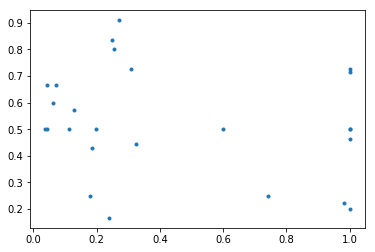

In [247]:
import matplotlib.pyplot as plt
plt.plot(single_word_portion, svm_f1_score, '.')
plt.show()

In [257]:
scipy.stats.spearmanr(single_word_portion, svm_f1_score)

SpearmanrResult(correlation=-0.1227739100639645, pvalue=0.5587758434122012)

In [235]:
#all_lit_texts = [' '.join(sublib) for sublib in reviewers_literature]
#for texts in all_lit_texts:
#    print(len(nltk.word_tokenize(texts)))

total number of words in training set

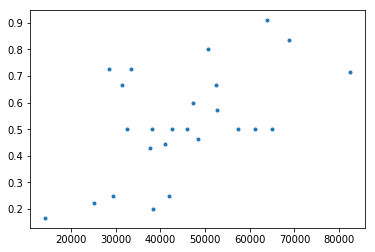

In [249]:
import matplotlib.pyplot as plt
plt.plot(np.sum(reviewers_literature_single_multiple_author_word_count,axis=1), svm_f1_score, '.')
plt.show()

In [255]:
import scipy
x = np.sum(reviewers_literature_single_multiple_author_word_count,axis=1)
y = svm_f1_score

In [256]:
scipy.stats.spearmanr(x, y)

SpearmanrResult(correlation=0.4737757646353846, pvalue=0.016738357454073687)